In [16]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np

In [17]:
from data import Dataloader
from models import RandomExampleModel
import metrics

In [18]:
# Loading the data
data_loader = Dataloader("../data/dataset_4") # Specify path to the dataset you want to load

n = 400
X, Y = data_loader.load()
X = X[:n]
Y = Y[:n]
print(X.shape)


(400, 4)


In [19]:
# Let's train an example model
model = RandomExampleModel() # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

In [20]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[-0.02918935  0.26452602]
 [-0.23504386 -0.06949957]
 [-0.00167842 -0.08688312]
 [-0.05042343 -0.25713769]
 [-0.04372049  0.0350513 ]]


In [21]:
# Or we can directly use the predict_preference method:
print(model.predict_preference(X, Y)[:5]) # For each cluster we see if X is preferred to Y (0) or the contrary (1)
# predict_preference returns preference of samples for each cluster, returning shape (n_samples, n_clusters)
# 0 means that the cluster prefers first argument (here X[i]), 1 means that the cluster prefers second argument (here Y[i])

[[0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]]


In [22]:
# We consider that our model explains our data, if for at least one cluster, X[i] >> Y[i]
pairs_explained = np.sum(model.predict_preference(X, Y)[:5] == 0, axis=1) # For each sample check if each clusters prefers X[i] (then is True)
pairs_explained = pairs_explained > 0 # If at least one cluster prefers X[i], then X[i] >> Y[i] is explained
print("Percentage of explained preferences for 5 first samples:", np.sum(pairs_explained) / 5) # Get % or explained pairs

Percentage of explained preferences for 5 first samples: 1.0


In [23]:
# Or we call directly the right metric:
pairs_explained = metrics.PairsExplained()
print("Percentage of explained preferences for all samples:", pairs_explained.from_model(model, X, Y))
# Or other possibility:
print("Percentage of explained preferences for all samples:", pairs_explained(model.predict_utility(X), model.predict_utility(Y)))

Percentage of explained preferences for all samples: 0.6525
Percentage of explained preferences for all samples: 0.6525


In [24]:
# Now, we can also see how our model clusters our data
print(model.predict_cluster(X, Y)[:5]) # Returns for each sample which cluster is the most likely to have generated the preference.
# The most likely cluster is the one with the highest utility difference U(X[i])-U(Y[i]) for the sample.

[1 1 0 0 1]


In [25]:
# Ground truth are also provided:
Z = data_loader.get_ground_truth_labels()
Z = Z[:n]
# We can see how it compares to our model's predictions:
print(Z[:5])

[0 0 0 1 0]


In [26]:
# We have a metric to calculate how well the model has regrouped the preferences pairs compared to ground truth:
cluster_intersection = metrics.ClusterIntersection()

print("Cluster intersection for 5 first samples:", cluster_intersection(model.predict_cluster(X, Y)[:5], Z[:5]))

# Then for all data:
print("Cluster intersection for all samples:", cluster_intersection(model.predict_cluster(X, Y), Z))
print("Cluster intersection for all samples:", cluster_intersection.from_model(model, X, Y, Z))

Cluster intersection for 5 first samples: 0.6
Cluster intersection for all samples: 0.5484837092731829
Cluster intersection for all samples: 0.5484837092731829


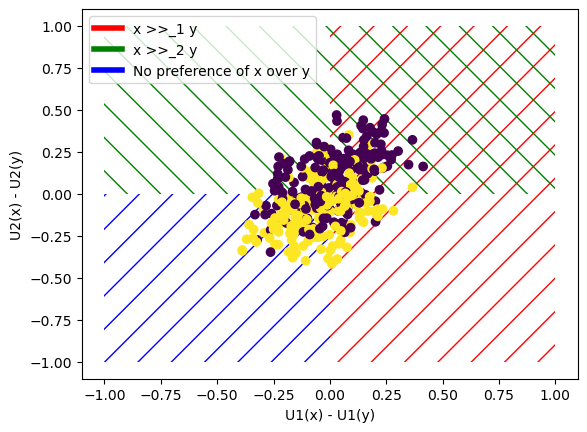

In [27]:
# Here is a proposition of a useful plot to see how the model clusters the data:
# We look at how each cluster evaluates U(x) - U(y) and color with ground truth clustering
# Note that x >>_1 y means that x is preferred to y for cluster 1
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

plt.figure()
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")

plt.gca().add_patch(Rectangle((0,-1.),1., 2.,
                    edgecolor='red',
                    facecolor='none',
                    lw=0, 
                    hatch='/'))
plt.gca().add_patch(Rectangle((-1.,0), 2., 1.,
                    edgecolor='green',
                    facecolor='none',
                    lw=0, 
                    hatch='\\'))
plt.gca().add_patch(Rectangle((-1.,-1.),1., 1.,
                    edgecolor='blue',
                    facecolor='none',
                    hatch='/',
                    lw=0))
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)

custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="b", lw=4)]

plt.legend(custom_lines, ['x >>_1 y', "x >>_2 y ", 'No preference of x over y'])
plt.show()

Our random model cannot explain a large part of our preference data. Your first assigment will be to write a Mixed-Interger Programming algorithm that will be able to do so.

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2050 rows, 2448 columns and 29616 nonzeros
Model fingerprint: 0x21129feb
Variable types: 1648 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [6e-06, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-04, 3e+00]
Presolve removed 16 rows and 808 columns
Presolve time: 0.05s
Presolved: 2034 rows, 1640 columns, 23980 nonzeros
Variable types: 840 continuous, 800 integer (800 binary)

Root relaxation: objective 0.000000e+00, 981 iterations, 0.05 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  18

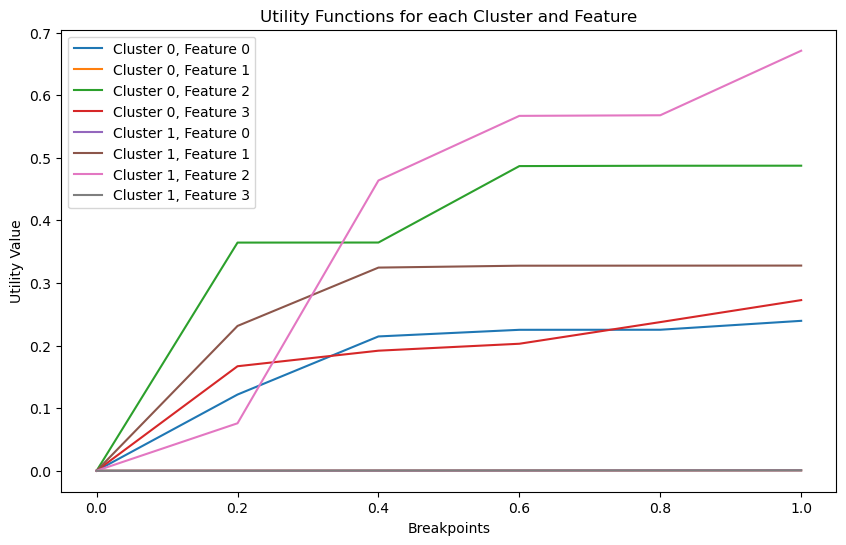

Percentage of explained preferences on train data: 0.9825
Percentage of preferences well regrouped into clusters: 0.960701754385965


In [28]:
# This cell should work when you have completed the TwoClustersMIP model
from models import TwoClustersMIP


parameters = {"n_pieces": 5,
              "n_clusters" : 2,
              } # Can be completed
model = TwoClustersMIP(**parameters) 
model.fit(X, Y)
# # Uncomment once your model is working
print("Percentage of explained preferences on train data:", pairs_explained.from_model(model, X, Y)) # You should get 1.0 with the right MIP
print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(model, X, Y, Z))




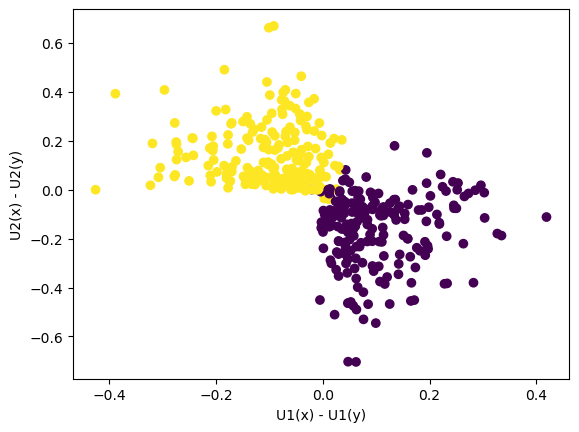

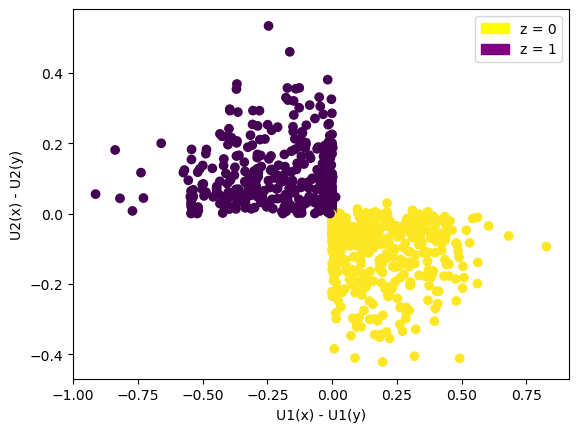

In [29]:
# As an example here are the results obtained with:
 # Uncomment the code to check your results
plt.figure()
plt.scatter(model.predict_utility(X)[:, 0]-model.predict_utility(Y)[:, 0], 
            model.predict_utility(X)[:, 1]-model.predict_utility(Y)[:, 1], c=Z)
plt.xlabel("U1(x) - U1(y)")
plt.ylabel("U2(x) - U2(y)")
plt.show()

# Here is how it should look like
from IPython.display import Image
Image("../images/MIP_results_example.png")

Your second assignement will be to find a model that will work well with larger data instances.

In [30]:
# from models import ImprovedHeuristicModel

# # Assuming X, Y are your training data
# parameters_heuristic = {"n_clusters": 2}  # You can adjust this parameter based on your requirement
# heuristic_model = ImprovedHeuristicModel(**parameters_heuristic)

# # Fit the heuristic model
# heuristic_model.fit(X, Y)

# # Evaluate the heuristic model
# print("Percentage of explained preferences on train data:", pairs_explained.from_model(heuristic_model, X, Y))
# print("Percentage of preferences well regrouped into clusters:", cluster_intersection.from_model(heuristic_model, X, Y, Z))
